# Initializing:

In [1]:
import base64
import cv2
import dnnlib
import glob
import gradio as gr
import io
import imageio
import legacy
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
import plotly.express as px
import plotly.graph_objs as go
import random
import shutil
import sklearn.decomposition as decomposition
import sklearn.manifold as manifold
import sklearn.preprocessing as preprocessing
import sklearn.utils as utils
import torch
import tqdm.notebook as tqdm

from dash import Dash, Input, Output, dcc, html, no_update
from PIL import Image
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings("ignore")

In [2]:
def colorSqueeze(r, g, b):
    return r / 255, g / 255, b / 255

jkuBlue = colorSqueeze(4, 110, 152)
jkuCyan = colorSqueeze(92,207,203)
jkuYellow = colorSqueeze(251,186,0)
jkuGrey = colorSqueeze(128,130,136)
jkuDarkGrey = colorSqueeze(90,90,90)
jkuLightGreen = colorSqueeze(187,208,50)
jkuGreen = colorSqueeze(76,172,78)
jkuPurple = colorSqueeze(156,71,123)
jkuRed = colorSqueeze(231,55,41)

colors=[jkuBlue, jkuLightGreen, jkuRed, jkuYellow]

In [3]:
# Path to the trained model
model_path = os.path.join(os.getcwd(), "models", "oct.pkl") # ["NORMAL", "CNV", "DRUSEN", "DME"]
model_path = os.path.join(os.getcwd(), "models", "oct_256_resized_1600.pkl") # ["DRUSEN", "NORMAL", "DME", "CNV"]

# Directory where temporary files should be stored
directory = os.path.join(os.getcwd(), "downprojection")

# Available classes to choose from
classes = ["DRUSEN", "NORMAL", "DME", "CNV"]
classes_dict = {"DRUSEN": 0, "NORMAL": 1, "DME": 2, "CNV": 3}
classes_dictN = {0:"DRUSEN", 1:"NORMAL", 2:"DME", 3:"CNV"}

# Torch device
device = torch.device('cuda')

# Generate Images:

In [4]:
directory = os.path.join(os.getcwd(), "downprojection")

# Check if the directory exists
if os.path.exists(directory):
    # If it exists, delete it and its contents
    shutil.rmtree(directory)
    
# Create the directory
os.mkdir(directory)

# Create subdirectories 0, 1, 2, 3, and "progression" within the main directory
subdirectories = ['0', '1', '2', '3', 'progression']
for subdir in subdirectories:
    os.mkdir(os.path.join(directory, subdir))

In [5]:
def moveNpy(src, dst):
    # Source and destination directory paths
    src_dir = src
    dst_dir = dst

    # Iterate over files in the source directory
    for filename in os.listdir(src_dir):
        if filename.endswith(".npy"):
            # Construct the full path to the file
            src_file = os.path.join(src_dir, filename)
            dst_file = os.path.join(dst_dir, filename)
            # Move the file to the destination directory
            shutil.move(src_file, dst_file)

In [6]:
random_seed = np.random.randint(1, 999999)
execution = f"python generate.py --outdir={os.path.join(os.getcwd(), 'downprojection', str(0))} --seeds={random_seed + 250*0}-{random_seed + 250*1-1} --network={model_path} --class={0} --vector-mode=False --silent-mode=True"
os.system(execution)  
moveNpy(os.path.join(os.getcwd(), "downprojection"), os.path.join(os.getcwd(), "downprojection", str(0)))
        
execution = f"python generate.py --outdir={os.path.join(os.getcwd(), 'downprojection', str(1))} --seeds={random_seed + 250*1}-{random_seed + 250*2-1} --network={model_path} --class={1} --vector-mode=False --silent-mode=True"
os.system(execution)  
moveNpy(os.path.join(os.getcwd(), "downprojection"), os.path.join(os.getcwd(), "downprojection", str(1)))
        
execution = f"python generate.py --outdir={os.path.join(os.getcwd(), 'downprojection', str(2))} --seeds={random_seed + 250*2}-{random_seed + 250*3-1} --network={model_path} --class={2} --vector-mode=False --silent-mode=True"
os.system(execution)  
moveNpy(os.path.join(os.getcwd(), "downprojection"), os.path.join(os.getcwd(), "downprojection", str(2)))
        
execution = f"python generate.py --outdir={os.path.join(os.getcwd(), 'downprojection', str(3))} --seeds={random_seed + 250*3}-{random_seed + 250*4-1} --network={model_path} --class={3} --vector-mode=False --silent-mode=True"
os.system(execution)  
moveNpy(os.path.join(os.getcwd(), "downprojection"), os.path.join(os.getcwd(), "downprojection", str(3)))

In [7]:
for i in range(4):
    cur_directory = os.path.join(os.getcwd(), "downprojection", str(i))
    
    # Get a list of all .npy files in the directory
    npy_files = [os.path.join(cur_directory, f) for f in os.listdir(cur_directory) if f.endswith('.npy')]
    npy_files = sorted(npy_files)

    # Get a list of all .png files in the directory
    png_files = [os.path.join(cur_directory, f) for f in os.listdir(cur_directory) if f.endswith('.png')]
    png_files = sorted(png_files)

    for j in range(len(npy_files)):    
        new_name = f"{str(j).zfill(4)}."
        os.rename(npy_files[j], os.path.join(cur_directory, new_name + 'npy'))
        os.rename(png_files[j], os.path.join(cur_directory, new_name + 'png'))

# Preprocess the image-vectors:

In [8]:
# Assume vectors is a numpy array with shape (1000, 14, 512)
files_0 = [f for f in os.listdir(os.path.join(os.getcwd(), directory, "0")) if f.endswith('.npy')]
files_1 = [f for f in os.listdir(os.path.join(os.getcwd(), directory, "1")) if f.endswith('.npy')]
files_2 = [f for f in os.listdir(os.path.join(os.getcwd(), directory, "2")) if f.endswith('.npy')]
files_3 = [f for f in os.listdir(os.path.join(os.getcwd(), directory, "3")) if f.endswith('.npy')]
        
# Define the vectors
vectors_0 = []
vectors_1 = []
vectors_2 = []
vectors_3 = []

# Append the vectors
for i in files_0:
    vectors_0.append(np.load(os.path.join(os.getcwd(), directory, "0", str(i))))
for i in files_1:
    vectors_1.append(np.load(os.path.join(os.getcwd(), directory, "1", str(i))))
for i in files_2:
    vectors_2.append(np.load(os.path.join(os.getcwd(), directory, "2", str(i))))
for i in files_3:
    vectors_3.append(np.load(os.path.join(os.getcwd(), directory, "3", str(i))))
    
# Make a numpy array
vectors_0 = np.array(vectors_0)
vectors_1 = np.array(vectors_1)
vectors_2 = np.array(vectors_2)
vectors_3 = np.array(vectors_3)

# Reshape the array
vectors_0 = vectors_0.reshape(len(files_0), -1)
vectors_1 = vectors_1.reshape(len(files_1), -1)
vectors_2 = vectors_2.reshape(len(files_2), -1)
vectors_3 = vectors_3.reshape(len(files_3), -1)

# Convert your list of datapoints to a numpy array of shape (250, 512)
data_0 = np.array(vectors_0).squeeze()
data_1 = np.array(vectors_1).squeeze()
data_2 = np.array(vectors_2).squeeze()
data_3 = np.array(vectors_3).squeeze()

In [9]:
vectors_0.shape

(250, 7168)

In [10]:
# Use glob to find all PNG files in the directory
files_0 = [os.path.join(os.path.join(os.getcwd(), directory, "0"), f) for f in os.listdir(os.path.join(os.getcwd(), directory, "0")) if f.endswith('.png')]
files_0 = sorted(files_0)
files_1 = [os.path.join(os.path.join(os.getcwd(), directory, "1"), f) for f in os.listdir(os.path.join(os.getcwd(), directory, "1")) if f.endswith('.png')]
files_1 = sorted(files_1)
files_2 = [os.path.join(os.path.join(os.getcwd(), directory, "2"), f) for f in os.listdir(os.path.join(os.getcwd(), directory, "2")) if f.endswith('.png')]
files_2 = sorted(files_2)
files_3 = [os.path.join(os.path.join(os.getcwd(), directory, "3"), f) for f in os.listdir(os.path.join(os.getcwd(), directory, "3")) if f.endswith('.png')]
files_3 = sorted(files_3)

files = np.concatenate((files_0, files_1, files_2, files_3))

# PCA

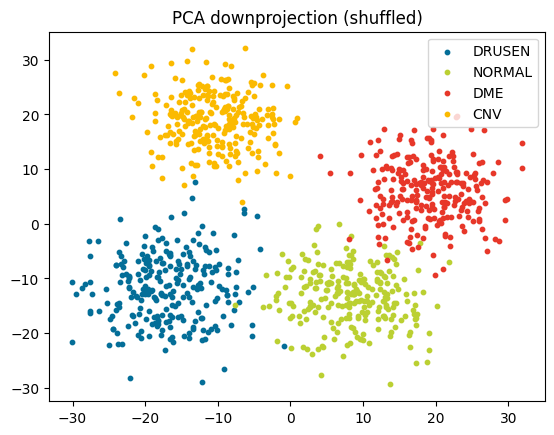

In [11]:
# Combine the data from the four classes into one dataset
data_combined = np.concatenate((data_0, data_1, data_2, data_3))

# Create an array with the corresponding labels for each datapoint
labels = np.concatenate((
    np.zeros(len(data_0)), 
    np.ones(len(data_1)), 
    2*np.ones(len(data_2)), 
    3*np.ones(len(data_3)),
))

# Shuffle the data and labels together
data_combined, labels, files = shuffle(data_combined, labels, files)#, random_state=42)

# Create a PCA object with n_components=2, which will project the data onto a 2D subspace
pca = PCA(n_components=2)

# Fit the PCA object to the data and transform the data onto the 2D subspace
pca_data = pca.fit_transform(data_combined)

# The pca_data array now contains the projected data in a 2D space
# plot the downprojected vectors
for i in range(4):
    plt.scatter(pca_data[labels==i, 0], pca_data[labels==i, 1], s=10, color=colors[i], label=classes_dictN[i])
plt.title('PCA downprojection (shuffled)')
plt.legend()
plt.show()

In [12]:
# Save the pca_data and the image_names
for i in range(4):
    x_y_pairs = pca_data[labels==i, :2] # Select only the first two columns (X and Y)
    filename = f"class_{i}_data.txt" # Name the file based on the class index
    np.savetxt(os.path.join(directory, filename), x_y_pairs) # Save the data to the file
    
np.save(os.path.join(directory, "image_names.npy"), files)

# t-SNE

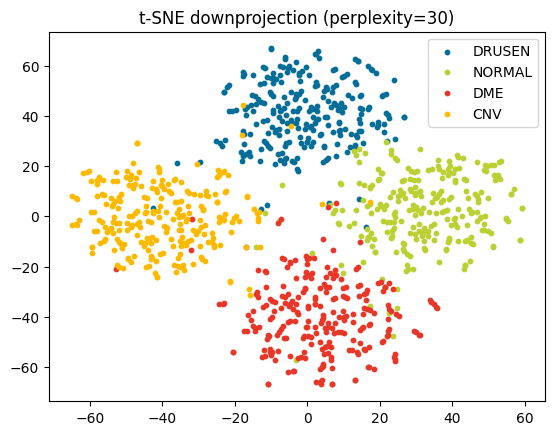

In [13]:
# Combine the data from the four classes into one dataset
data_combined = np.concatenate((data_0, data_1, data_2, data_3))

# Create an array with the corresponding labels for each datapoint
labels = np.concatenate((
    np.zeros(len(data_0)), 
    np.ones(len(data_1)), 
    2*np.ones(len(data_2)), 
    3*np.ones(len(data_3)),
))

# Apply t-SNE with 2 components
tsne = TSNE(n_components=2, perplexity=5)

# Fit the t-SNE object to the data and transform the data onto the 2D subspace
tsne_data = tsne.fit_transform(data_combined)

# Plot the downprojected vectors
for i in range(4):
    plt.scatter(tsne_data[labels==i, 0], tsne_data[labels==i, 1], s=10, color=colors[i], label=classes_dictN[i])
plt.title('t-SNE downprojection (perplexity=30)')
plt.legend()
plt.show()

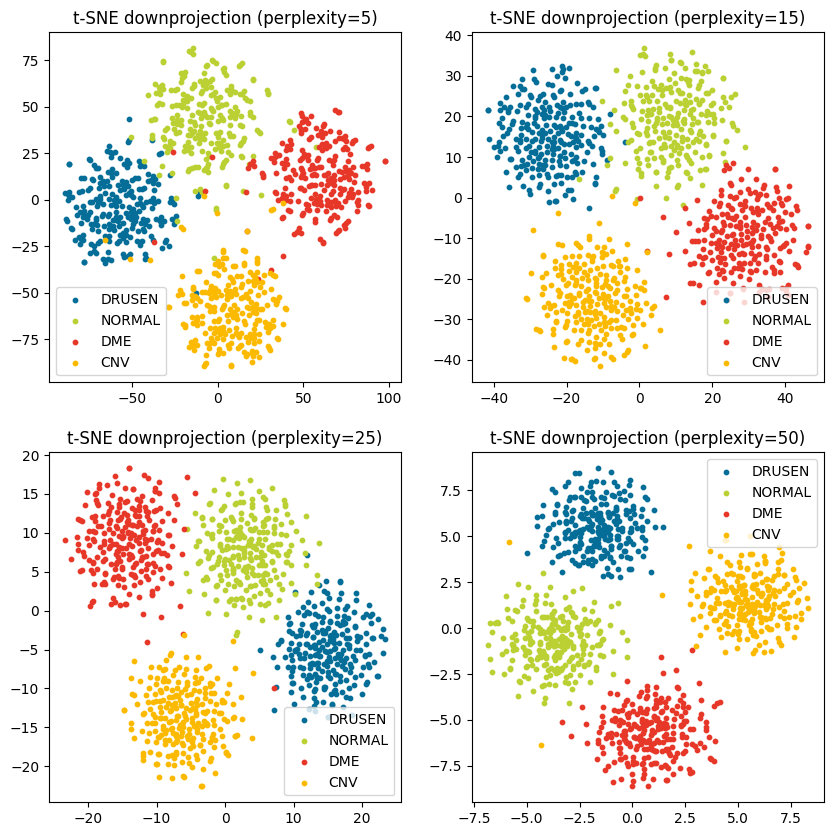

In [14]:
# Combine the data from the four classes into one dataset
data_combined = np.concatenate((data_0, data_1, data_2, data_3))

# Create an array with the corresponding labels for each datapoint
labels = np.concatenate((
    np.zeros(len(data_0)), 
    np.ones(len(data_1)), 
    2*np.ones(len(data_2)), 
    3*np.ones(len(data_3)),
))

# Shuffle the data and labels together
data_combined, labels = shuffle(data_combined, labels)#, random_state=42)

# Standardize the data
scaler = StandardScaler()
data_combined = scaler.fit_transform(data_combined)

# Create a list of perplexity values to use
perplexities = [5, 15, 25, 50]

# Create a 2x2 plot with subplots for each perplexity value
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Loop over the perplexity values and create a plot for each one
for i, perplexity in enumerate(perplexities):
    # Apply t-SNE with 2 components and the current perplexity value
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=5000)
    tsne_data = tsne.fit_transform(data_combined)
    
    # Plot the downprojected vectors on the current subplot
    ax = axs[i // 2, i % 2]
    for j in range(4):
        ax.scatter(tsne_data[labels==j, 0], tsne_data[labels==j, 1], s=10, color=colors[j], label=classes_dictN[j])
    ax.set_title(f"t-SNE downprojection (perplexity={perplexity})")
    ax.legend()

plt.show()

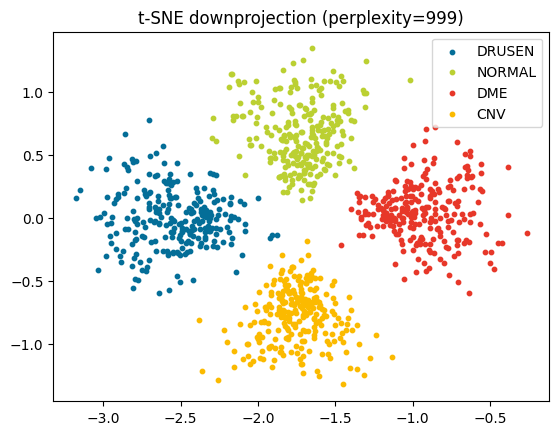

In [15]:
# Combine the data from the four classes into one dataset
data_combined = np.concatenate((data_0, data_1, data_2, data_3))

# Create an array with the corresponding labels for each datapoint
labels = np.concatenate((
    np.zeros(len(data_0)), 
    np.ones(len(data_1)), 
    2*np.ones(len(data_2)), 
    3*np.ones(len(data_3)),
))

# Apply t-SNE with 2 components
tsne = TSNE(n_components=2, perplexity=800, n_iter=1000)

# Fit the t-SNE object to the data and transform the data onto the 2D subspace
tsne_data = tsne.fit_transform(data_combined)

# plot the downprojected vectors
for i in range(4):
    plt.scatter(tsne_data[labels==i, 0], tsne_data[labels==i, 1], s=10, color=colors[i], label=classes_dictN[i])
plt.title('t-SNE downprojection (perplexity=999)')
plt.legend()
plt.show()

In [16]:
# Save the pca_data and the image_names
for i in range(4):
    x_y_pairs = tsne_data[labels==i, :2] # Select only the first two columns (X and Y)
    filename = f"class_{i}_data.txt" # Name the file based on the class index
    np.savetxt(os.path.join(directory, filename), x_y_pairs) # Save the data to the file
    
np.save(os.path.join(directory, "image_names.npy"), files)

# Load a (1, 14, 512) latent representation:

In [17]:
current = np.load(os.path.join(os.getcwd(), "downprojection", "0", "0000.npy"))
current.shape

(1, 14, 512)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


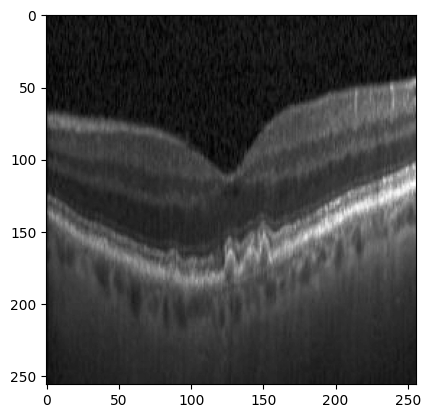

In [18]:
with dnnlib.util.open_url(model_path) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)  # type: ignore

z = torch.from_numpy(current).to(device)
synth_image = G.synthesis(z, noise_mode='const')
synth_image = (synth_image + 1) * (255 / 2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

# Display the image using imshow()
plt.imshow(synth_image, cmap='gray')

# Show the plot
plt.show()

# Analyze how an image gets generated

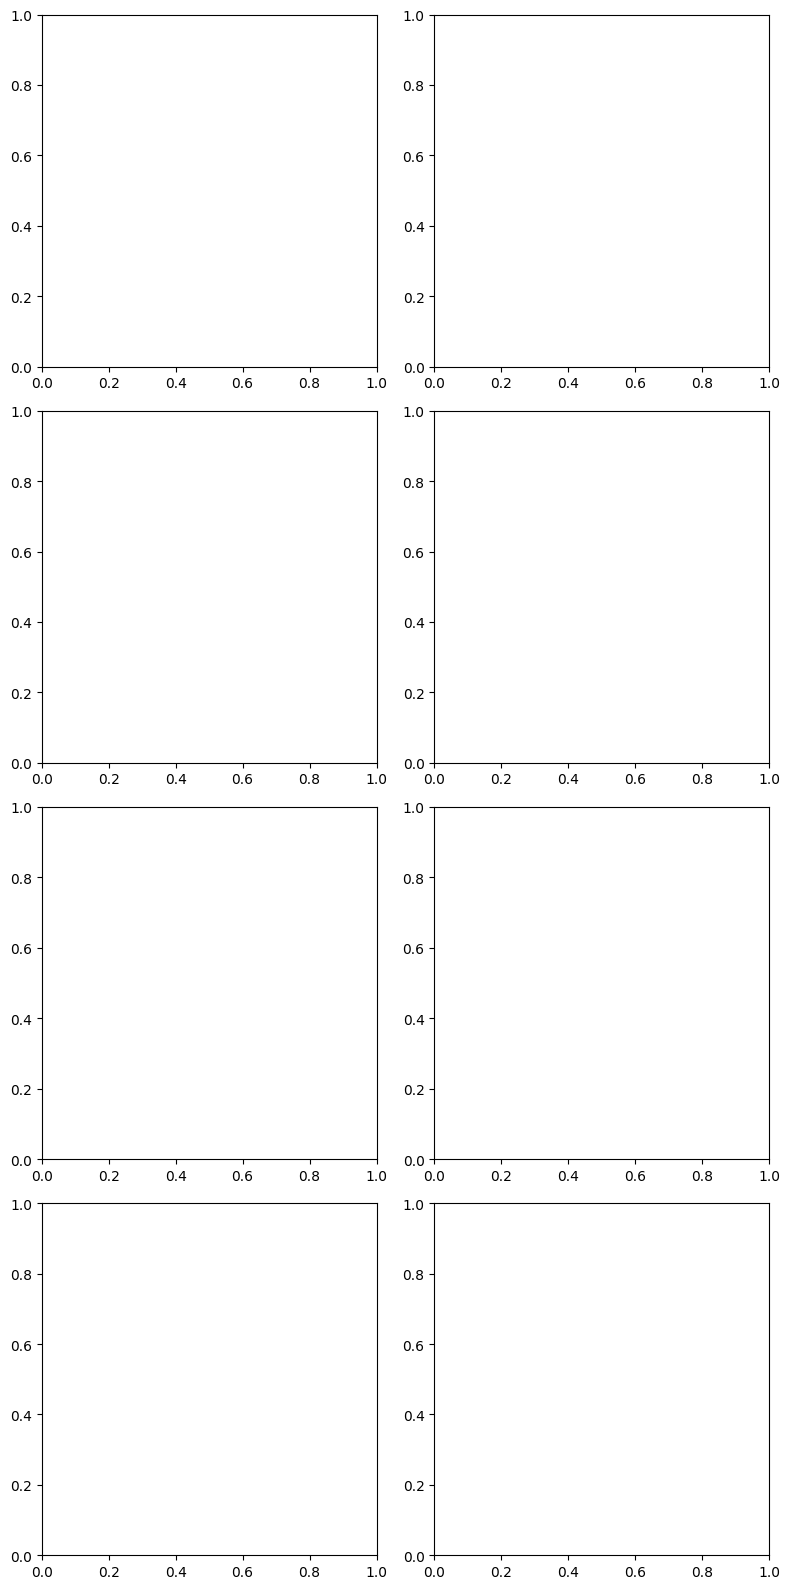

In [19]:
# npy_files = glob.glob('downprojection/progression/*.npy')
npy_files = glob.glob(os.path.join(os.getcwd(), "progession", "*.npy"))

npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[2]))

# create a 4x2 subplot grid
fig, axs = plt.subplots(4, 2, figsize=(8, 16))

# loop through the filenames and plot each image in the corresponding subplot
for i, filename in enumerate(npy_files):
    row = i // 2
    col = i % 2
    
    image_vector = np.load(filename)

    # reshape the array to (size, size)
    if filename.startswith(os.path.join(os.getcwd(), "progession", "/1_1_")):
        img = image_vector[0][0]
    else:
        current = np.load(filename)
        
        with dnnlib.util.open_url(model_path) as fp:
            G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)  # type: ignore

        z = torch.from_numpy(current).to(device)
        img = G.synthesis(z, noise_mode='const')
        img = (img + 1) * (255 / 2)
        img = img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    # plot the image in the corresponding subplot
    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].set_title(f'{filename[27:]}')

plt.tight_layout()
plt.show()

# Image Map

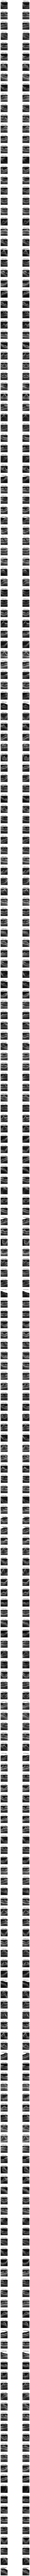

In [20]:
dir_path = os.path.join(os.getcwd(), "downprojection", str(2))

# Get all .npy and .png files in the directory
npy_files = [f for f in os.listdir(dir_path) if f.endswith('.npy')]
png_files = [f for f in os.listdir(dir_path) if f.endswith('.png')]

# Sort the lists alphabetically
npy_files.sort()
png_files.sort()

# Check that there are the same number of files
if len(npy_files) != len(png_files):
    raise ValueError('Number of .npy and .png files do not match')

# Create a subplot with n rows and 2 columns, where n is the number of files
num_files = len(npy_files)
fig, axs = plt.subplots(num_files, 2, figsize=(8, 2*num_files))
# fig, axs = plt.subplots(num_files, 2, figsize=(10, 4*num_files))


# Loop through each file and plot them in pairs
for i in range(num_files):
    # Load the .npy file
    npy_file = np.load(os.path.join(dir_path, npy_files[i]))    
    z = torch.from_numpy(npy_file).to(device)
    synth_image = G.synthesis(z, noise_mode='const')
    synth_image = (synth_image + 1) * (255 / 2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    npy_file = synth_image
    
    # Load the corresponding .png file
    png_file = plt.imread(os.path.join(dir_path, png_files[i]))
    
    # Plot the images side-by-side
    axs[i, 0].imshow(npy_file, cmap='gray')
    axs[i, 1].imshow(png_file, cmap='gray')
    
    # Set the titles to the file names
    axs[i, 0].set_title(npy_files[i])
    axs[i, 1].set_title(png_files[i])
    
    # Remove axis ticks
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.1)

# Show the plot
plt.show()